In [36]:
import torch.nn as nn

# 2-1

## load, augment and struct the training dataset

# Train dataset

In [37]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
torch.set_default_device(device)
torch.manual_seed(42)

device

'cuda'

In [38]:
import random
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, ConcatDataset

generator = torch.Generator(device=device)
rotation_degrees = 20
translation_percent = 0.1
validation_ratio = 0.2

transform_list = [
    transforms.RandomRotation(degrees=(-rotation_degrees, rotation_degrees)),
    transforms.RandomAffine(degrees=0, translate=(translation_percent, translation_percent)),
    transforms.RandomVerticalFlip(p=0.5),
    
]

data_dir = "./TRAIN/"
batch_size = 400

# Original dataset without augmentation
original_dataset = ImageFolder(root=data_dir, transform=transforms.ToTensor())

augmented = []
for index, (data, label) in enumerate(original_dataset):
    images = []
    for transform in transform_list:
        if random.random() > 0.15:
            transformed_data = transform(data)
            images.append(transformed_data)
            if len(images) >= 2 and random.random() > 0.50:
                transformed_data = transform(images[-2])
                images.append(transformed_data)
    else:
        for image in images:  augmented.append((image, label))
        
        
        

class AugmentedCustomDataset(Dataset):
    def __init__(self, augmented_data):
        self.augmented_data = augmented_data

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        images, label = self.augmented_data[idx]
        tensor_images = [torch.Tensor(image) for image in images]
        combined_images = torch.stack(tensor_images)
        
        return combined_images, label

custom_augmented_dataset = AugmentedCustomDataset(augmented)
combined_dataset = torch.utils.data.ConcatDataset([original_dataset, custom_augmented_dataset])

val_size = int(len(combined_dataset) * validation_ratio)
train_size = int(len(combined_dataset) - val_size)



In [39]:
device

'cuda'

In [40]:
generator = torch.Generator(device=device)
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size], generator=generator)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=250, shuffle=True,generator=torch.Generator(device='cuda'))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=250, shuffle=False,generator=torch.Generator(device='cuda'))

# Fine tune dataset

In [51]:


data_dir = './TUNE/'
data_transforms = transforms.Compose([
    transforms.ToTensor()
])
custom_dataset = ImageFolder(root=data_dir, transform=data_transforms)

batch_size = 400 
val_size = int(len(custom_dataset) * 0.3)
train_size = int(len(custom_dataset) - val_size)


generator = torch.Generator(device=device)
train_dataset_ft, val_dataset_ft = torch.utils.data.random_split(custom_dataset, [train_size, val_size],generator=generator)
train_loader_ft = torch.utils.data.DataLoader(train_dataset_ft, batch_size=20, shuffle=True,generator=torch.Generator(device='cuda'))
val_loader_ft = torch.utils.data.DataLoader(val_dataset_ft, batch_size=10, shuffle=False,generator=torch.Generator(device='cuda'))

# 3-1

In [42]:
import torch.nn as nn



import torch.nn as nn

class GaussianDropout(nn.Module):

    def __init__(self, p: float):

        super().__init__()
        assert 0 <= p < 1
        self.t_mean = torch.ones((0,))
        self.shape = ()
        self.p = p
        self.t_std = self.compute_std()

    def compute_std(self):
        return self.p / (1 - self.p)

    def forward(self, t_hidden):
        if self.training and self.p > 0.:
            if self.t_mean.shape != t_hidden.shape:
                self.t_mean = torch.ones_like(input=t_hidden
                                              , dtype=t_hidden.dtype
                                              , device=t_hidden.device)
            elif self.t_mean.device != t_hidden.device:
                self.t_mean = self.t_mean.to(device=t_hidden.device, dtype=t_hidden.dtype)

            t_gaussian_noise = torch.normal(self.t_mean, self.t_std)
            t_hidden = t_hidden.mul(t_gaussian_noise)
        return t_hidden


class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, padding=4)
        self.bn1 = nn.BatchNorm2d(16, affine=False)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm2d(32, affine=False)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64, affine=False)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128, affine=False)
        self.conv_5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128, affine=False)
        self.drop_out_gus = GaussianDropout(0.2)
        self.max_pool = nn.MaxPool2d(2)
        self.dropout_pool = nn.Dropout(p=0.5)
        
        self.flatten = nn.Flatten(1)
        self.dense_1 = nn.Linear(2048, 1024)
        self.dense_2 = nn.Linear(1024, 1024)
        
        self.output = nn.Linear(1024, 8)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.max_pool(x)
        x = self.drop_out_gus(x)


        x = self.conv_2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.max_pool(x)
        x = self.drop_out_gus(x)

        
        x = self.conv_3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.max_pool(x)
        x = self.drop_out_gus(x)


        x = self.conv_4(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.max_pool(x)
        x = self.drop_out_gus(x)


        x = self.conv_5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.drop_out_gus(x)

        x = self.flatten(x)
        x = self.dense_1(x)

        x = self.dropout_pool(x)
        
        x = self.dense_2(x)
        x = self.dropout_pool(x)
        
        x = self.output(x)
        return x


In [43]:
import torch.optim as optim

alex_net = AlexNet().to(device).float()
optimizer = optim.Adam(alex_net.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()

# Training

In [44]:
num_epochs = 24

metrics_train = {
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': [],
}
for epoch in range(num_epochs):
    alex_net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alex_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    alex_net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alex_net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    metrics_train['train_accuracy'].append(train_accuracy)
    metrics_train['val_accuracy'].append(val_accuracy)
    metrics_train['train_loss'].append(epoch_loss)
    metrics_train['val_loss'].append(epoch_val_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")

Epoch [1/24] - Loss: 2.6185 - Val Loss: 2.5452 - Train Acc: 13.70% - Val Acc: 15.98%
Epoch [2/24] - Loss: 2.5967 - Val Loss: 2.4818 - Train Acc: 14.66% - Val Acc: 15.27%
Epoch [3/24] - Loss: 2.4392 - Val Loss: 2.2474 - Train Acc: 14.40% - Val Acc: 17.20%
Epoch [4/24] - Loss: 2.1496 - Val Loss: 2.0004 - Train Acc: 17.84% - Val Acc: 20.50%
Epoch [5/24] - Loss: 1.8998 - Val Loss: 2.0004 - Train Acc: 24.95% - Val Acc: 20.96%
Epoch [6/24] - Loss: 1.8136 - Val Loss: 1.7090 - Train Acc: 28.71% - Val Acc: 33.01%
Epoch [7/24] - Loss: 1.6505 - Val Loss: 1.5914 - Train Acc: 35.86% - Val Acc: 37.47%
Epoch [8/24] - Loss: 1.5337 - Val Loss: 1.5752 - Train Acc: 39.54% - Val Acc: 37.39%
Epoch [9/24] - Loss: 1.4541 - Val Loss: 1.4506 - Train Acc: 42.31% - Val Acc: 42.63%
Epoch [10/24] - Loss: 1.3694 - Val Loss: 1.4284 - Train Acc: 45.78% - Val Acc: 44.23%
Epoch [11/24] - Loss: 1.3147 - Val Loss: 1.3341 - Train Acc: 48.55% - Val Acc: 48.43%
Epoch [12/24] - Loss: 1.2579 - Val Loss: 1.7472 - Train Acc: 51

# Fine-tuning

In [53]:
epochs =  30
metrics_val = {
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': [],
}

for epoch in range(epochs):
    alex_net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    

    for inputs, labels in train_loader_ft:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alex_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    alex_net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader_ft:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alex_net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    epoch_loss = running_loss / len(train_loader_ft)
    epoch_val_loss = val_loss / len(val_loader_ft)
    metrics_val['train_accuracy'].append(train_accuracy)
    metrics_val['val_accuracy'].append(val_accuracy)
    metrics_val['train_loss'].append(epoch_loss)
    metrics_val['val_loss'].append(epoch_val_loss)
    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")

Epoch [1/16] - Loss: 1.6298 - Val Loss: 1.6704 - Train Acc: 39.73% - Val Acc: 41.67%
Epoch [2/16] - Loss: 1.5278 - Val Loss: 1.5626 - Train Acc: 45.45% - Val Acc: 41.25%
Epoch [3/16] - Loss: 1.5700 - Val Loss: 1.7878 - Train Acc: 47.05% - Val Acc: 36.88%
Epoch [4/16] - Loss: 1.4191 - Val Loss: 2.1009 - Train Acc: 50.36% - Val Acc: 32.08%
Epoch [5/16] - Loss: 1.7340 - Val Loss: 3.3628 - Train Acc: 46.61% - Val Acc: 28.12%
Epoch [6/16] - Loss: 2.3005 - Val Loss: 1.8510 - Train Acc: 37.95% - Val Acc: 33.54%
Epoch [7/16] - Loss: 1.3119 - Val Loss: 2.0802 - Train Acc: 53.48% - Val Acc: 38.96%
Epoch [8/16] - Loss: 1.2978 - Val Loss: 1.7784 - Train Acc: 57.68% - Val Acc: 42.92%
Epoch [9/16] - Loss: 1.3952 - Val Loss: 2.2070 - Train Acc: 55.00% - Val Acc: 33.75%
Epoch [10/16] - Loss: 1.4631 - Val Loss: 2.2981 - Train Acc: 57.14% - Val Acc: 35.21%
Epoch [11/16] - Loss: 1.2987 - Val Loss: 3.2224 - Train Acc: 61.79% - Val Acc: 32.08%
Epoch [12/16] - Loss: 1.3613 - Val Loss: 2.8803 - Train Acc: 59

Classification Report:
              precision    recall  f1-score   support

     class_0       0.20      0.60      0.30        42
     class_1       0.29      0.58      0.38        52
     class_2       0.56      0.08      0.15        59
     class_3       0.62      0.22      0.32        69
     class_4       0.84      0.46      0.59        70
     class_5       0.16      0.46      0.24        59
     class_6       0.33      0.01      0.03        68
     class_7       0.50      0.10      0.16        61

    accuracy                           0.29       480
   macro avg       0.44      0.31      0.27       480
weighted avg       0.46      0.29      0.27       480



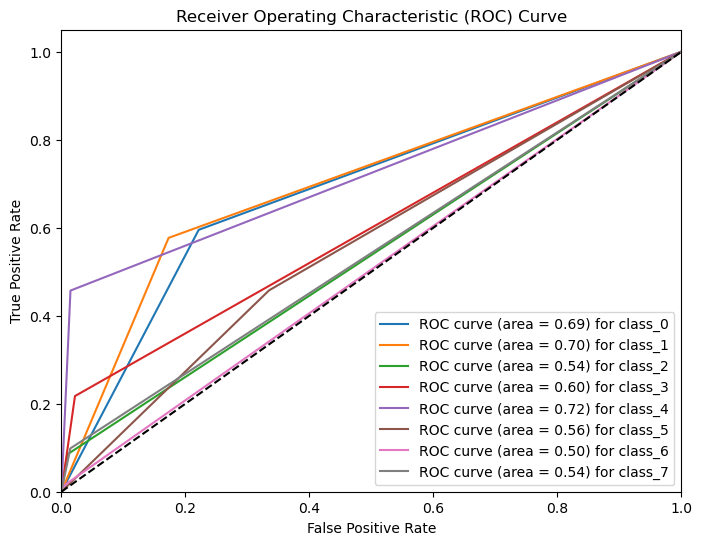

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_true = []  # Ground truth
y_pred = []
with torch.no_grad():
        for inputs, labels in val_loader_ft:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alex_net(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7']
classification_rep = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(classification_rep)

cm = confusion_matrix(y_true, y_pred)


# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
num_classes = len(class_names)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_names[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

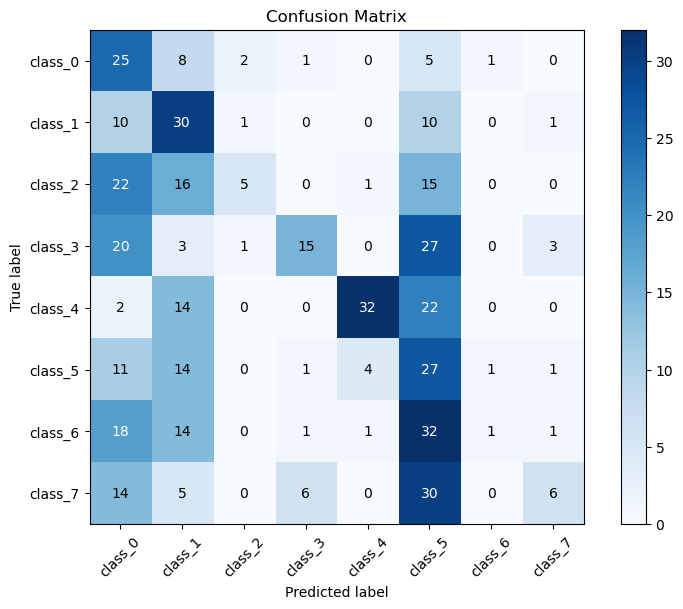

In [56]:
 # Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [58]:
class_names

['class_0',
 'class_1',
 'class_2',
 'class_3',
 'class_4',
 'class_5',
 'class_6',
 'class_7']